In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.constants as const
from sn_companion_collision.sn_collision import kasen, get_filter_trans

from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

from scipy.signal import savgol_filter

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
t_bmax = 58863.34
t_fl = -17.4928

abs_mag_df = pd.read_csv('../plots/abs_mag_p48.csv')

# Ni clumps

Following the method in  Magee & Maguire 2020, we have developed a model with a clump of $^{56}$Ni in the outer ejecta of the SN to see if that can replicate the observations of SN 2019yvq.

In [4]:
spec = pd.read_csv('../data/models/Ni_clump/Clump_Spectra.out')
no_clump_spec = pd.read_csv('../data/models/Ni_clump/NoClump_Spectra.out')

spec.head()

,0.750,1.250,1.750,2.250,2.750,3.250,3.750,4.250,4.750,5.250,...,25.250,25.750,26.250,26.750,27.250,27.750,28.250,28.750,29.250,Wavelength
0,0.006933,0.013147,0.016209,0.015864,0.011975,0.009677,0.007324,0.006297,0.005301,0.005528,...,0.003837,0.002369,0.001751,0.001219,0.000901,0.000539,0.000279,0.000103,0.000013,3505.0
1,0.007442,0.013358,0.017063,0.015620,0.013043,0.009972,0.008199,0.006620,0.005274,0.005492,...,0.003815,0.002570,0.001830,0.001570,0.001080,0.000585,0.000244,0.000107,0.000031,3515.0
2,0.007563,0.014606,0.018286,0.016518,0.013473,0.009521,0.007823,0.006513,0.005643,0.005811,...,0.003705,0.002521,0.002012,0.001615,0.001028,0.000665,0.000242,0.000073,0.000065,3525.0
3,0.007490,0.015339,0.019037,0.017961,0.014648,0.009671,0.008002,0.006700,0.006073,0.005508,...,0.003654,0.002550,0.002029,0.001484,0.001104,0.000568,0.000219,0.000133,0.000012,3535.0
4,0.007139,0.015432,0.019843,0.019166,0.015133,0.010502,0.007797,0.007410,0.006479,0.005806,...,0.003818,0.002637,0.002178,0.001516,0.001087,0.000663,0.000315,0.000121,0.000014,3545.0


In [5]:
no_clump = pd.read_csv('../data/models/Ni_clump/NoClump_Lightcurve.out', delim_whitespace=True)
clump = pd.read_csv('../data/models/Ni_clump/Clump_Lightcurve.out', delim_whitespace=True)
no_clump.head()

,Time,gZ,rZ,iZ
0,0.75,-7.418430,-5.729040,-7.760111
1,1.25,-6.668423,-7.137040,-8.588734
2,1.75,-6.659226,-7.492690,-9.250645
3,2.25,-8.210069,-9.416983,-10.781544
4,2.75,-9.649765,-10.750660,-12.016296


In [6]:
g_ztf = get_filter_trans.get_g_ztf_tc()
r_ztf = get_filter_trans.get_r_ztf_tc()
i_ztf = get_filter_trans.get_i_ztf_tc()

uvm2 = get_filter_trans.get_uvm2_tc()
uvw1 = get_filter_trans.get_uvw1_tc()
uvw2 = get_filter_trans.get_uvw2_tc()

/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:93: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  self.wavelength.max())[0]
/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting

In [7]:
t_Ni = spec.columns.values[:-1].astype(float)
g_Ni = np.zeros_like(t_Ni)
r_Ni = np.zeros_like(t_Ni)
i_Ni = np.zeros_like(t_Ni)

for t_step, time in enumerate(t_Ni):
    Ni_spec = kasen.Spectrum(spec.Wavelength, spec['{:.3f}'.format(time)])
    syn_phot = np.zeros(6)
    for filt_num, filt in enumerate([g_ztf, r_ztf, i_ztf]):
        f_lambda = Ni_spec.SyntheticPhotometry(filt)
        f_nu = f_lambda * filt.wavelength_eff**2/const.c.to('Angstrom/s').value * 1e23
        syn_phot[filt_num] = -2.5*np.log10(f_nu/3631)
    
    g_Ni[t_step] = syn_phot[0]
    r_Ni[t_step] = syn_phot[1]
    i_Ni[t_step] = syn_phot[2]

g_no_clump = np.zeros_like(t_Ni)
r_no_clump = np.zeros_like(t_Ni)
i_no_clump = np.zeros_like(t_Ni)

for t_step, time in enumerate(t_Ni):
    Ni_spec = kasen.Spectrum(no_clump_spec.Wavelength, no_clump_spec['{:.3f}'.format(time)])
    syn_phot = np.zeros(6)
    for filt_num, filt in enumerate([g_ztf, r_ztf, i_ztf]):
        f_lambda = Ni_spec.SyntheticPhotometry(filt)
        f_nu = f_lambda * filt.wavelength_eff**2/const.c.to('Angstrom/s').value * 1e23
        syn_phot[filt_num] = -2.5*np.log10(f_nu/3631)
    
    g_no_clump[t_step] = syn_phot[0]
    r_no_clump[t_step] = syn_phot[1]
    i_no_clump[t_step] = syn_phot[2]



/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:131: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func, self.wavelength.min(), self.wavelength.max())[0]


<IPython.core.display.Javascript object>


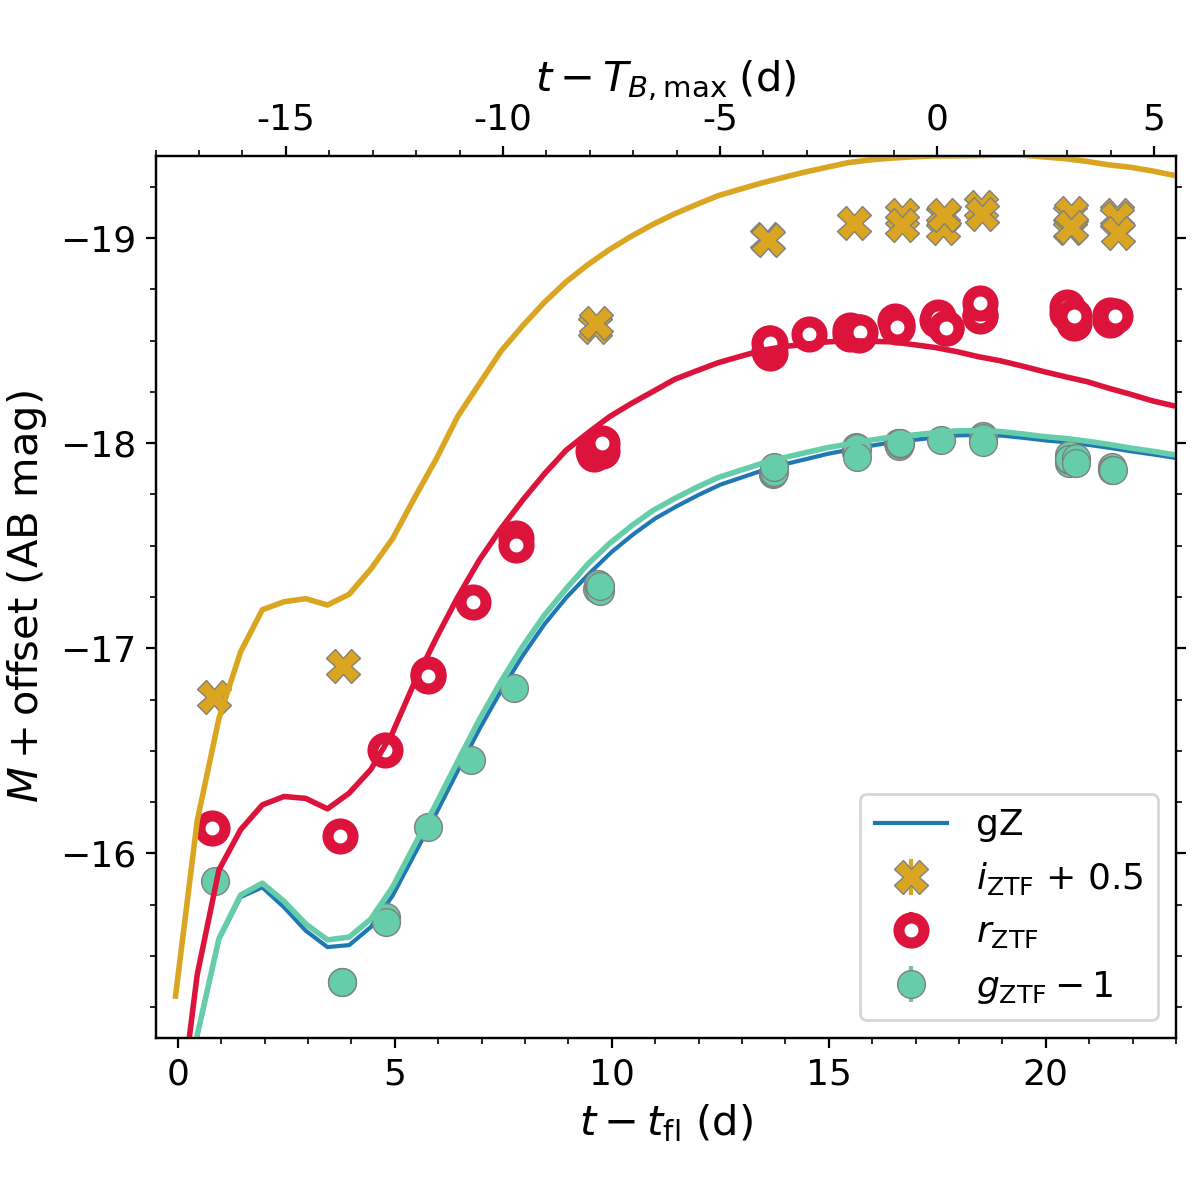

In [8]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 4,
            1: 0.5,
            3: 0.5}
ms_dict = {2: 9,
           1: 10,
           3: 12}
filt_dict = {1:'g', 
             2:'r', 
             3:'i'}
label_dict = {1:r'$g_\mathrm{ZTF} - 1$', 
             2:r'$r_\mathrm{ZTF}$', 
             3:r'$i_\mathrm{ZTF}$ + 0.5'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}
offset_dict = {3: -1,
               1: +0.5,
               2: 0,
               "uvw2": 4,
               "uvm2": 2,
               "uvw1": 2}

t_offset  = 0.8
model_offset = 0.1

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(t_Ni-t_offset, 
        g_Ni + offset_dict[1] + model_offset, 
        color=color_dict[1], 
        lw=2, zorder=100)
ax.plot(t_Ni-t_offset, 
        r_Ni + offset_dict[2] + model_offset, 
        color=color_dict[2], 
        lw=2, zorder=100)
ax.plot(t_Ni-t_offset, 
        i_Ni + offset_dict[3] + model_offset, 
        color=color_dict[3], 
        lw=2, zorder=100)

ax.plot(clump.Time - t_offset,
        clump.gZ + offset_dict[1] + model_offset)


for filt in [3,2,1]:
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])


ax.set_ylim(-15.1, -19.4)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-0.5, 23)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', right=True, labelsize=13)

ax.legend(loc=4, fontsize=13) #,bbox_to_anchor=(0.5,0.53,0,0))

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,10,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 20, 41) - t_fl))
ax2.tick_params(labelsize=13)


fig.subplots_adjust(top=0.87,right=0.98,bottom=0.135, left=0.13)
# fig.savefig('../paper/figures/double_det.pdf')

### Plot the spectra

In [9]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

<IPython.core.display.Javascript object>


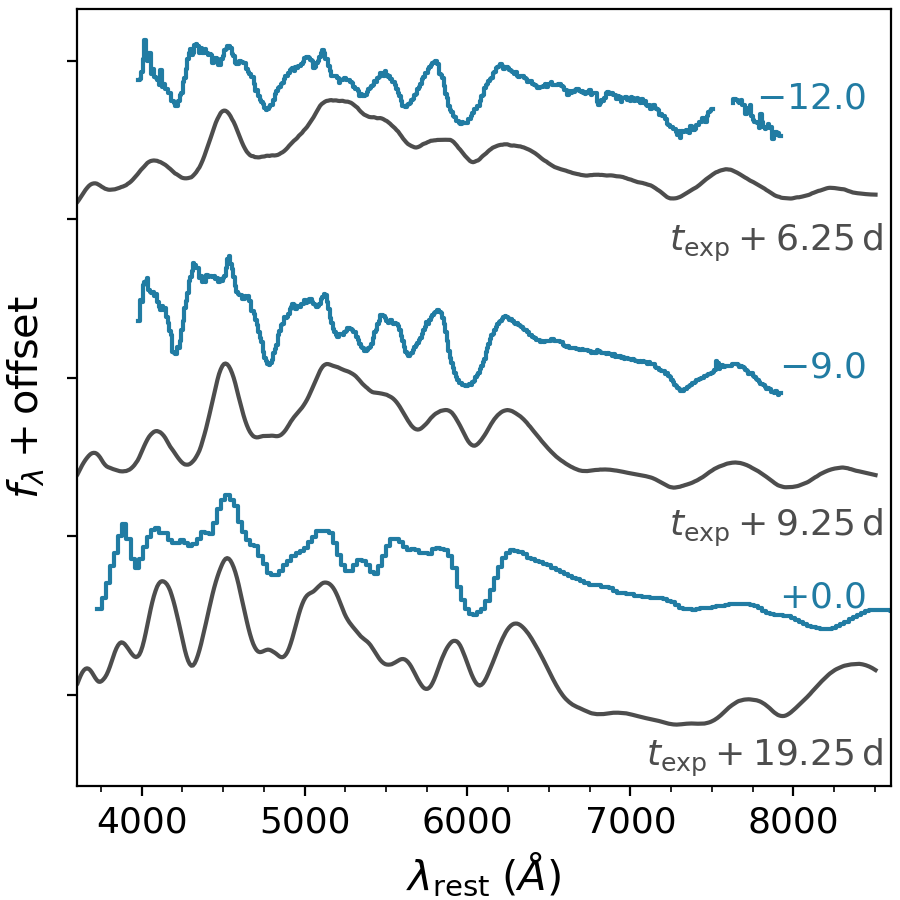

In [10]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

fig, ax_spec = plt.subplots(figsize=(4.5,4.5))

# plot the spectra

# 6.25 d after explosion = -12 phase spectrum
norm_flux = np.median(spec['6.250'].values[np.where((spec.Wavelength > 6400) & (spec.Wavelength < 6600))])
ax_spec.plot(spec.Wavelength, savgol_filter(spec['6.250'].values, 21, 2)/norm_flux - 0.3,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200103_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
plot_blue = np.where(wv < 7585)
ax_spec.plot(wv[plot_blue]/(1+z), fl[plot_blue]/norm_flux + 0.7, color=aam_colors['blue'])
plot_red = np.where(wv > 7700)
ax_spec.plot(wv[plot_red]/(1+z), fl[plot_red]/norm_flux + 0.7, color=aam_colors['blue'])

ax_spec.text(8450, 1.4, r'$-12.0$', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -0.4, r'$t_\mathrm{exp} + 6.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 9.250 d after explosion = -9 phase spectrum
norm_flux = np.median(spec['9.250'].values[np.where((spec.Wavelength > 6400) & (spec.Wavelength < 6600))])
ax_spec.plot(spec.Wavelength, savgol_filter(spec['9.250'].values, 21, 2)/norm_flux - 3.9,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200106_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux -2.5, color=aam_colors['blue'])

ax_spec.text(8450, -2., r'$-9.0$', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -4., r'$t_\mathrm{exp} + 9.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 19.250 d after explosion = +0 phase spectrum
norm_flux = np.median(spec['18.250'].values[np.where((spec.Wavelength > 6400) & (spec.Wavelength < 6600))])
ax_spec.plot(spec.Wavelength, savgol_filter(spec['18.250'].values, 21, 2)/norm_flux - 6.7,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200115_P60_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux - 5.3, color=aam_colors['blue'])

ax_spec.text(8450, -4.9, r'$+0.0$', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -6.9, r'$t_\mathrm{exp} + 19.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')


ax_spec.set_xlim(3600,8600)
ax_spec.set_yticklabels([])
ax_spec.set_ylabel(r'$f_\lambda + \mathrm{offset}$', fontsize=15)
ax_spec.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$', fontsize=15)
ax_spec.set_ylim(-7.15,2.65)
ax_spec.tick_params(labelsize=13)
ax_spec.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(top=0.99,bottom=0.127,right=0.99,left=0.085)
# fig.savefig('../paper/figures/clump_spec.pdf')

## Put it all together

<IPython.core.display.Javascript object>


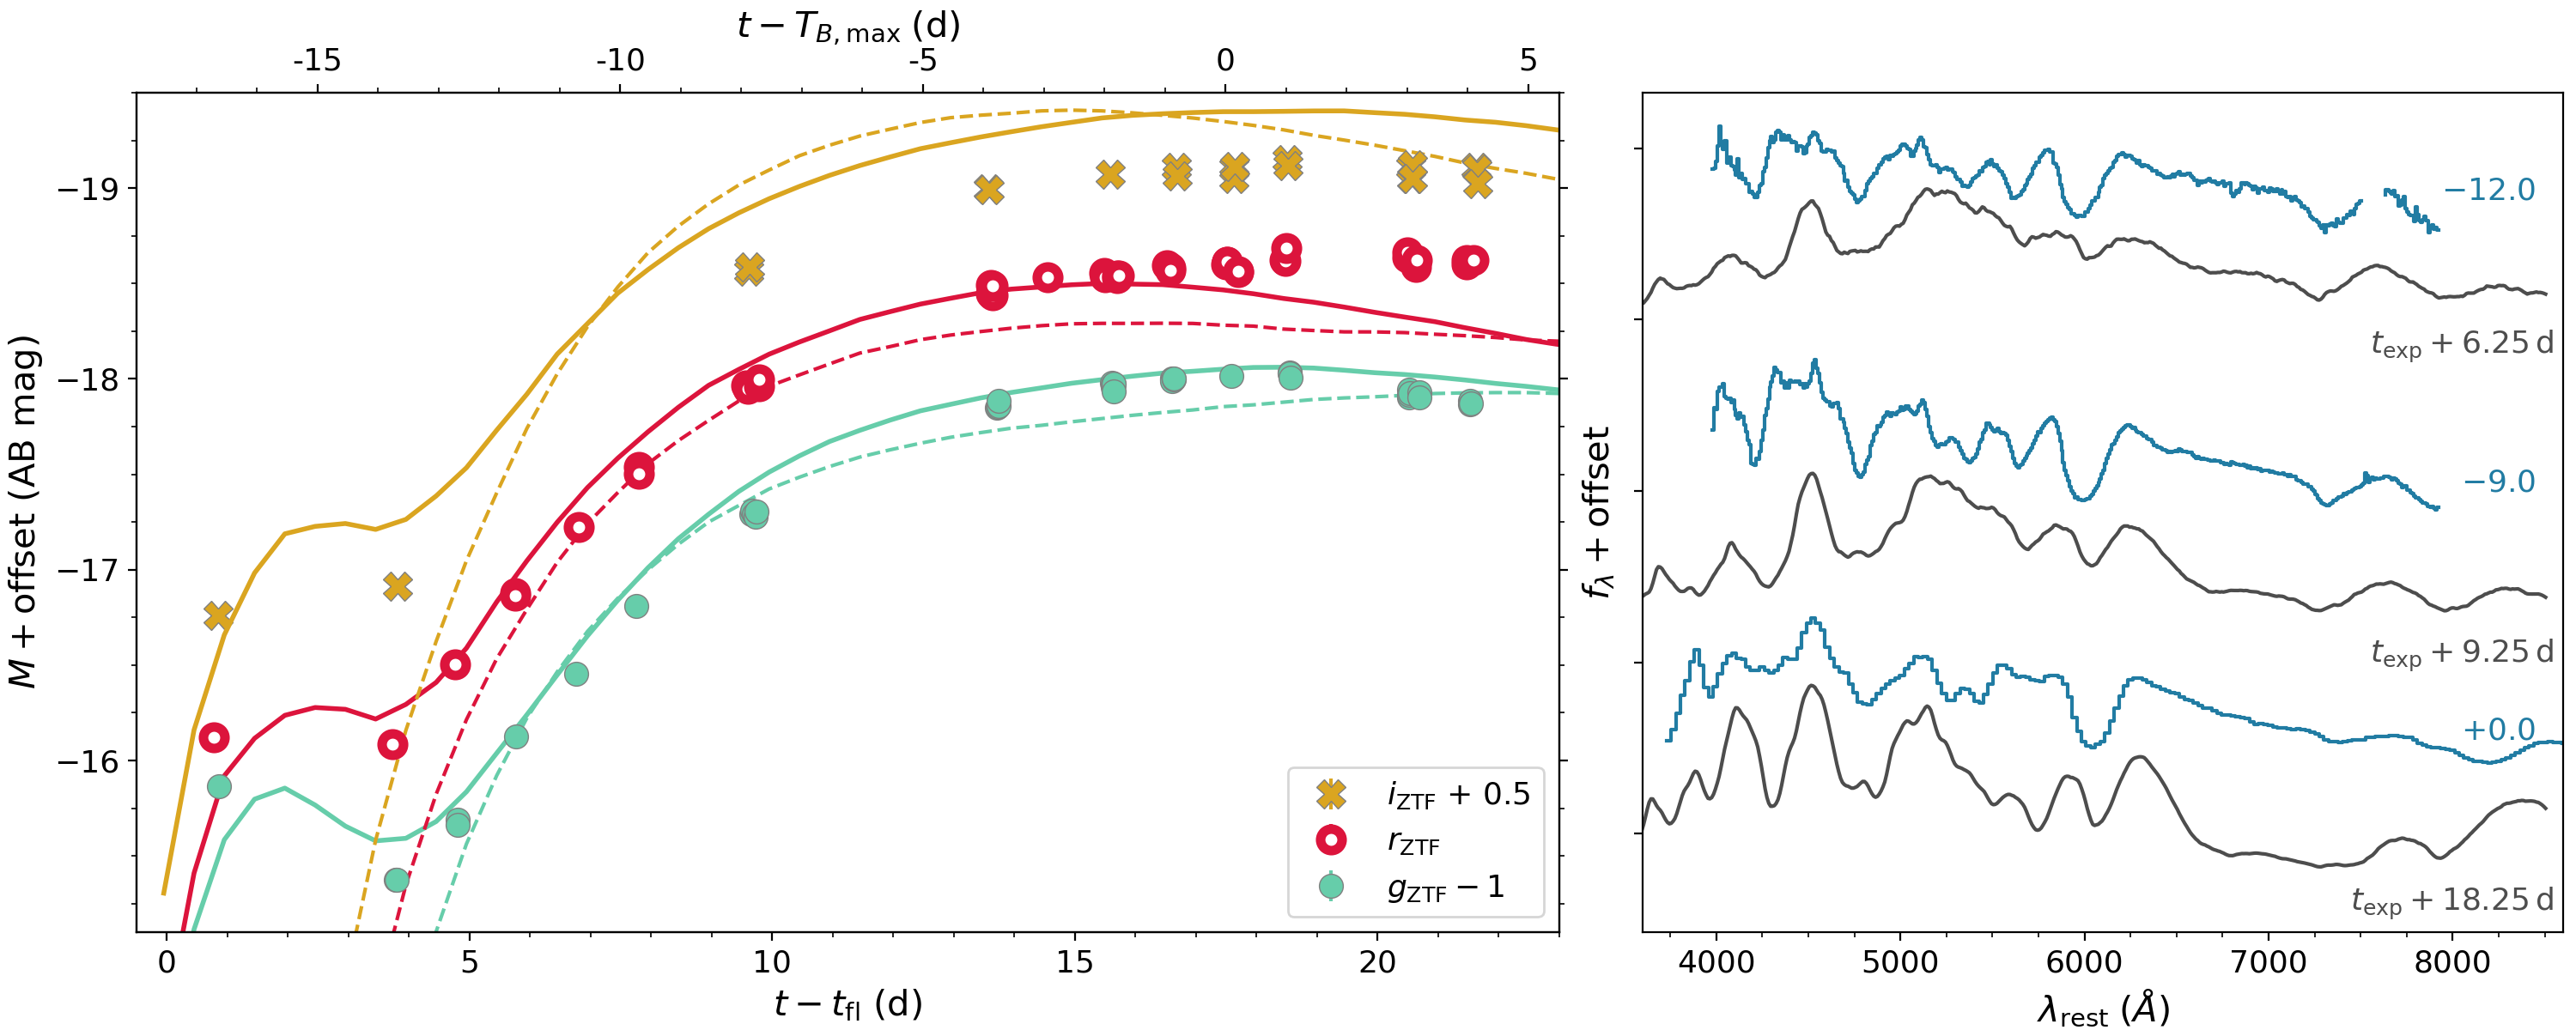

In [12]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

fig = plt.figure(figsize=(15,6), constrained_layout=True)

gs = GridSpec(1, 5, figure=fig)
ax = fig.add_subplot(gs[:, 0:3])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax_spec = fig.add_subplot(gs[:, 3:])

t_offset  = 0.8
model_offset = 0.1
ax.plot(t_Ni-t_offset, 
        g_Ni + offset_dict[1] + model_offset, 
        color=color_dict[1], 
        lw=2, zorder=-100)
ax.plot(t_Ni-t_offset,
        g_no_clump + offset_dict[1],
        '--', color=color_dict[1])

ax.plot(t_Ni-t_offset, 
        r_Ni + offset_dict[2] + model_offset, 
        color=color_dict[2], 
        lw=2, zorder=-100)
ax.plot(t_Ni-t_offset,
        r_no_clump + offset_dict[2],
        '--', color=color_dict[2])

ax.plot(t_Ni-t_offset, 
        i_Ni + offset_dict[3] + model_offset, 
        color=color_dict[3], 
        lw=2, zorder=100)
ax.plot(t_Ni-t_offset,
        i_no_clump + offset_dict[3],
        '--', color=color_dict[3])


for filt in [3,2,1]:
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])


ax.set_ylim(-15.1, -19.5)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-0.5, 23)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', right=True, labelsize=13)

ax.legend(loc=4, fontsize=13) #,bbox_to_anchor=(0.5,0.53,0,0))

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,10,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 20, 41) - t_fl))
ax2.tick_params(labelsize=13)


# PLOT SPECTRA
# 6.25 d after explosion = -12 phase spectrum
norm_flux = np.median(spec['6.250'].values[np.where((spec.Wavelength > 6400) & (spec.Wavelength < 6600))])
ax_spec.plot(spec.Wavelength, savgol_filter(spec['6.250'].values, 7, 2)/norm_flux - 0.3,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200103_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
plot_blue = np.where(wv < 7585)
ax_spec.plot(wv[plot_blue]/(1+z), fl[plot_blue]/norm_flux + 0.7, color=aam_colors['blue'])
plot_red = np.where(wv > 7700)
ax_spec.plot(wv[plot_red]/(1+z), fl[plot_red]/norm_flux + 0.7, color=aam_colors['blue'])

ax_spec.text(8450, 1.4, r'$-12.0$', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -0.4, r'$t_\mathrm{exp} + 6.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 9.250 d after explosion = -9 phase spectrum
norm_flux = np.median(spec['9.250'].values[np.where((spec.Wavelength > 6400) & (spec.Wavelength < 6600))])
ax_spec.plot(spec.Wavelength, savgol_filter(spec['9.250'].values, 7, 2)/norm_flux - 3.9,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200106_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux -2.5, color=aam_colors['blue'])

ax_spec.text(8450, -2., r'$-9.0$', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -4., r'$t_\mathrm{exp} + 9.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 18.250 d after explosion = +0 phase spectrum
norm_flux = np.median(spec['18.250'].values[np.where((spec.Wavelength > 6400) & (spec.Wavelength < 6600))])
ax_spec.plot(spec.Wavelength, savgol_filter(spec['18.250'].values, 7, 2)/norm_flux - 6.7,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200115_P60_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux - 5.3, color=aam_colors['blue'])

ax_spec.text(8450, -4.9, r'$+0.0$', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -6.9, r'$t_\mathrm{exp} + 18.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')


ax_spec.set_xlim(3600,8600)
ax_spec.set_yticklabels([])
ax_spec.set_ylabel(r'$f_\lambda + \mathrm{offset}$', fontsize=15)
ax_spec.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$', fontsize=15)
ax_spec.set_ylim(-7.15,2.65)
ax_spec.tick_params(labelsize=13)
ax_spec.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(top=0.91,bottom=0.095,right=0.995,left=0.053)
fig.savefig('../paper/figures/clump_model.pdf')